### Blog Generation from youtube transcript 

In [51]:
import os
from typing import Optional, TypedDict, Dict, Any
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from youtube_transcript_api import YouTubeTranscriptApi
from langchain_community.tools import TavilySearchResults
import re
from IPython.display import Markdown, display

In [52]:
# Load environment variables
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

web_search_tool = TavilySearchResults(k=3)

### Integration with Langsmith for evaluation

In [53]:
os.environ["LANGSMITH_PROJECT"] = "Youtube-blog-generator"


In [54]:
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"

In [55]:
# LLMs
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct", temperature = 0.6)
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000021EF178F650>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021EF17BC2C0>, model_name='meta-llama/llama-4-scout-17b-16e-instruct', temperature=0.6, model_kwargs={}, groq_api_key=SecretStr('**********'))

### Defining the State

In [56]:
class State(TypedDict):
    video_url: str
    transcript: Optional[str]
    title: Optional[str]
    blog_content: Optional[str]
    review_feedback: Optional[str]
    refine_blog: Optional[bool]
    search_query: Optional[str] 
    search_results: Optional[str]
    additional_comments: Optional[str]

In [57]:
##Extract video url
def extract_video_id(url):
    patterns = [
        r'(?:https?:\/\/)?(?:www\.)?youtube\.com\/watch\?v=([^&\s]+)',
        r'(?:https?:\/\/)?(?:www\.)?youtube\.com\/embed\/([^&\s]+)',
        r'(?:https?:\/\/)?(?:www\.)?youtu\.be\/([^&\s]+)'
    ]
    for pattern in patterns:
        match = re.search(pattern, url)
        if match:
            return match.group(1)
    raise ValueError("Invalid YouTube URL")

In [58]:
##Fetching Transcript from YouTube

def Document_Loader(state: State) -> State:
    try:
        video_id = extract_video_id(state['video_url'])
        transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
        transcript = " ".join([entry['text'] for entry in transcript_list])
        return {**state, 'transcript': transcript}
    except Exception as e:
        return {**state, 'transcript': "Unable to load transcript."}

In [59]:
def Title_Generator(state: State) -> State:  
    if not state['transcript'] or state['transcript'] == "Unable to load transcript.":
        return {**state, 'title': "Could not generate title due to transcript loading issue."}  
    prompt = f"Generate a only one catchy and relevant title for a blog post based on the following transcript:\n\nTranscript:\n{state['transcript']}\n Note: Just give only one title."
    title = llm.invoke(prompt)    
    return {**state, 'title': title.content}   

In [60]:
def Web_Search(state: State) -> State:
    search_query = state.get('title', '').strip()
    if not search_query:
        transcript = state.get('transcript', '')
        if transcript and transcript != "Unable to load transcript.":
            search_query = " ".join(transcript.split()[:100])
        else:
            return {**state, 'search_results': 'No search query could be generated.'}

    try:
        results = web_search_tool.run(search_query)
        return {**state, 'search_query': search_query, 'search_results': results}
    except Exception as e:
        return {**state, 'search_results': f"An error occurred during web search: {e}"}

In [61]:
def Blog_Creator(state: State) -> State:
    if not state['transcript'] or state['transcript'] == "Unable to load transcript.":
        return {**state, 'blog_content': "Could not generate blog content due to transcript loading issue."}
    
    prompt = f"Create a comprehensive and engaging blog post from the following transcript. " \
             f"Use the following web search results for additional context and enrichment. " \
             f"Ensure the content is well-structured, informative, and captures the key points.\n\n" \
             f"Transcript:\n{state['transcript']}\n\n" \
             f"Web Search Results:\n{state.get('search_results', 'No search results.')}"
    blog_content = llm.invoke(prompt)
    return {**state, 'blog_content': blog_content.content}

In [62]:
def Reviewer(state: State) -> State:
    review_prompt = f"Review the following blog post and provide constructive feedback:\n\n{state['blog_content']}"
    feedback = llm.invoke(review_prompt)
    return {**state, 'review_feedback': feedback.content}

In [63]:
def HumanFeedback(state: State) -> State:
    return state

In [64]:
def Blog_Refiner(state: State) -> State:
    if state.get('refine_blog', False):
        refined_prompt = f"Refine the following blog post based on these comments: {state['additional_comments']}\n\nOriginal Blog:\n{state['blog_content']}"
        refined_blog_content = llm.invoke(refined_prompt)
        return {**state, 'blog_content': refined_blog_content.content}
    return state

In [65]:
def should_continue(state: State, refine_blog: bool, additional_comments: Optional[str] = None) -> State:
    return {**state, 'refine_blog': refine_blog, 'additional_comments': additional_comments}

### Graph Structure

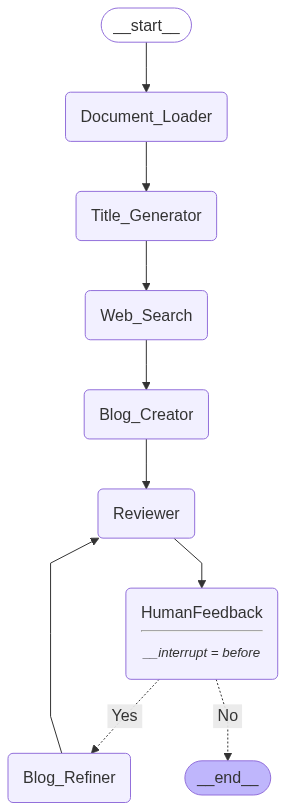

In [66]:
builder = StateGraph(State)

## add nodes
builder.add_node("Document_Loader", Document_Loader)
builder.add_node("Blog_Creator", Blog_Creator)
builder.add_node("Title_Generator", Title_Generator)
builder.add_node("Web_Search", Web_Search)
builder.add_node("Reviewer", Reviewer)
builder.add_node("HumanFeedback", HumanFeedback)
builder.add_node("Blog_Refiner", Blog_Refiner)

## add edges
builder.add_edge(START, "Document_Loader")
builder.add_edge("Document_Loader", "Title_Generator")
builder.add_edge("Title_Generator", "Web_Search")
builder.add_edge("Web_Search", "Blog_Creator")
builder.add_edge("Blog_Creator", "Reviewer")
builder.add_edge("Reviewer", "HumanFeedback")
builder.add_conditional_edges(
    "HumanFeedback",
    lambda state: "Yes" if state.get('refine_blog', False) else "No",
    {
        "No": END,
        "Yes": "Blog_Refiner",
    }
)
builder.add_edge("Blog_Refiner", "Reviewer")


graph = builder.compile(interrupt_before=['HumanFeedback'])
graph

In [67]:
video_url = input("Please provide the YouTube link for blog generation: ")
initial_state = {
    'video_url': video_url,
}
output_state = graph.invoke(initial_state)
print("\n--- Generated Blog Content ---")
display(Markdown(output_state.get('blog_content', 'No blog content generated.')))


--- Generated Blog Content ---


**Discover the Hidden Paradise: 5 Essential Things to Know Before Traveling to Andaman**

Welcome to the enchanting islands of Andaman, a haven for nature lovers, adventure seekers, and those looking to unwind in a tropical paradise. As you plan your trip to this breathtaking destination, here are five crucial things to keep in mind to make the most of your journey.

**1. Network Issues: Disconnect to Reconnect**

As you step into the Andaman Islands, be prepared to experience a digital detox. Network issues are common, and you may find yourself disconnected from the world, especially on Havelock Island. While some resorts and hotels offer Wi-Fi connectivity, it's not a guarantee. Recently, the Indian government announced the launch of high-speed broadband connectivity through the undersea optical fiber cable project, providing a lifeline to the digital world. However, we recommend taking a break from social media and immersing yourself in the island's serene beauty.

**2. Sea Walk: A Journey Under the Sea**

One of the most unique experiences in Andaman is the sea walk, a must-do activity on your itinerary. Explore the underwater world, teeming with colorful fish, coral life, and other marine animals like sea urchins, sea cucumbers, and oysters. You might even encounter friendly fish that might "kiss" your fingers! Choose from two locations: Elephant Beach on Havelock Island or North Bay Island. Don't miss this opportunity, as high tides might close the sea walk area.

**3. Best Time to Visit: Winter Wonderland**

The winter season is the ideal time to visit Andaman, with temperatures ranging from 22°C to 31°C and lower humidity levels in January and December. This is the perfect time to shake off the winter blues and enjoy a jacket-free vacation. As you arrive at Port Blair airport, you'll be thrilled to leave your winter gear behind.

**4. Carry Snacks and Drinking Water: Be Self-Sufficient**

When exploring the smaller islands like Jolly Boy Island and Ross Island, you might find limited food and water options. It's essential to carry your own snacks and drinking water to keep you going throughout the day. Remember to be eco-friendly and avoid polluting the islands.

**5. Trip to Baratang: Explore the Limestone Caves**

Your journey to Andaman begins at 3:30 a.m. with a trip to Baratang, where you'll explore the limestone caves. Don't forget to wear comfortable shoes, as you'll need to trek a short distance. Photography is strictly prohibited while entering the tropical forest, home to the Jarva tribes. However, you can capture memories after exiting the forest.

**Additional Tips and Insights**

* **Travel Documents:** Don't forget to carry your passport, visa, and Restricted Area Permit (RAP) for certain areas.
* **Mobile Connectivity and Wi-Fi:** While mobile connectivity is improving, it's still limited. Consider investing in a local SIM or portable Wi-Fi hotspot.
* **Responsible Tourism:** Be mindful of your surroundings and respect the local environment and tribes. Avoid visiting North Sentinel Island, home to the isolated Sentinelese tribe.
* **Activities and Adventures:** Try mangrove kayaking, island hopping, and discover the vibrant marine life. Visit Radhanagar Beach, Mahatma Gandhi Marine National Park, and explore the islands' lush grasslands, home to over 270 species of birds.

**Conclusion**

Andaman Islands offer a unique blend of adventure, nature, and relaxation. With these essential tips, you're ready to embark on an unforgettable journey. Remember to be respectful of the environment, local tribes, and fellow travelers. Book your flight, pack your bags, and get ready to experience the beauty of Andaman.

**Sources:**

* Official Website of Andaman & Nicobar Tourism: [www.andamantourism.gov.in](http://www.andamantourism.gov.in)
* Symphony Resorts: [www.symphonyresorts.com/blogs/things-to-keep-in-mind-while-traveling-to-andaman.html](http://www.symphonyresorts.com/blogs/things-to-keep-in-mind-while-traveling-to-andaman.html)
* Thrilling Travel: [thrillingtravel.in/travel-guide-andamans-nicobar-india.html](http://thrillingtravel.in/travel-guide-andamans-nicobar-india.html)
* Go2Andaman: [www.go2andaman.com/andaman-nicobar-islands/](http://www.go2andaman.com/andaman-nicobar-islands/)

Happy travels!

In [68]:
refine_blog_input = input("\nDo you want to refine the blog? (Yes/No): ").strip().lower()
refine_blog = refine_blog_input == "yes"
    
additional_comments = None
if refine_blog:
    additional_comments = input("Please provide additional comments to refine the blog: ").strip()
output_state = should_continue(output_state, refine_blog, additional_comments)
if refine_blog:
    output_state = graph.invoke(output_state)
    print("\n--- Refined Blog Content ---")
    display(Markdown(output_state.get('blog_content', 'No refined blog content generated.')))


--- Refined Blog Content ---


**Discover the Hidden Paradise: 5 Essential Things to Know Before Traveling to Andaman**

Are you ready to escape to a tropical paradise? The Andaman and Nicobar Islands are a haven for travelers seeking adventure, relaxation, and breathtaking natural beauty. Before you plan your trip to this Indian archipelago, here are five important things to know to make the most of your journey.

**1. Network Issues: Be Prepared for a Digital Detox**

When traveling to Andaman, be prepared for limited network connectivity. The island's remote location can make it challenging to stay connected to the outside world. During a previous visit, one traveler experienced zero network connectivity, making it essential to plan ahead and take breaks from social media. Although the Indian government has recently announced high-speed broadband connectivity through the undersea optical fiber cable project, connecting Chennai to Port Blair and other islands, it's still a good idea to disconnect and immerse yourself in nature.

**2. Seawalk: A Unique Underwater Experience**

A seawalk is a must-do experience in Andaman, offering a glimpse into an underwater world teeming with colorful fish, coral life, and other marine animals. You can take a seawalk at Elephant Beach in Havelock Island or North Bay Island. Be aware that high tides might cause the activity to be closed, so plan accordingly. This adventure activity is a unique opportunity to explore the ocean without requiring swimming.

**3. Best Time to Visit: Winter Wonderland**

The winter season, from December to January, is the best time to visit Andaman, with average temperatures ranging from 22°C to 31°C. The pleasant weather makes it ideal for outdoor activities like snorkeling, scuba diving, and exploring the islands. If you're looking for a jacket-free winter vacation, plan your trip during this time.

**4. Carry Snacks and Drinking Water: Be Self-Sufficient**

When visiting small islands like Jolly Boy Island and Ross Island, you might find limited food and water options. Carry your own snacks and drinking water to ensure you stay hydrated and energized throughout the day. Remember to dispose of your waste responsibly and avoid polluting the islands.

**5. Trip to Baratang: Respect the Tribal Land**

A trip to Baratang Island is a must, but it requires some planning. The journey begins at 3:30 a.m., and photography is strictly prohibited while entering the tropical forest, home to the Jarva tribes. Wear comfortable shoes, as you'll need to trek to the limestone caves. Be respectful of the tribal land and avoid mingling with the inhabitants to preserve their way of life.

**Additional Tips for a Smooth Journey**

* **Pack wisely**: Bring light cotton clothes for summer, a light cardigan for winters, dark sunglasses, an umbrella, raincoat, and trekking shoes if you plan to trek to Madhuban.
* **Carry cash**: There are limited ATMs on the islands, so it's essential to carry sufficient cash in INR. You can exchange currency at the airport or in Port Blair.
* **Respect the environment**: Avoid damaging coral reefs and refrain from touching poisonous fish and corals while snorkeling and diving.
* **Be mindful of local culture**: Respect the Jarva tribes and their land, and avoid mingling with them to preserve their way of life.

**Conclusion**

The Andaman and Nicobar Islands are a treasure trove of natural wonders, rich history, and vibrant culture. With these essential tips, you're ready to plan an unforgettable journey to this Indian paradise. From network issues to seawalk experiences, and from the best time to visit to respecting the tribal land, we've got you covered. So pack your bags, grab your sunscreen, and get ready to experience the beauty of Andaman!

**Recommended Resources**

For more information and insider tips, check out these websites:

* [Quora: What should I know before travelling to Andaman & Nicobar?](https://www.quora.com/What-should-I-know-before-travelling-to-Andaman-Nicobar)
* [Go2Andaman: Travel Guide to the Andaman Islands](https://www.go2andaman.com/andaman-nicobar-islands/)
* [Thrilling Travel: A guide to plan a trip to Andaman](https://thrillingtravel.in/travel-guide-andamans-nicobar-india.html)
* [MakeMyTrip: Andamans - A Quick and Handy Travel Guide](https://www.makemytrip.com/tripideas/blog/andamans-quick-travel-guide)
* [TravelTriangle: Andaman Travel Tips](https://traveltriangle.com/blog/andaman-travel-tips/)